In [1]:
import patsy
from patsy import dmatrices
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
from sklearn.model_selection import GridSearchCV
import copy
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import sklearn as sk
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
import seaborn as sns

C:\Users\cslun\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
elo = pd.read_csv('regseason_elo.csv')
elo['team'] = elo['Team']
regdf = pd.read_csv("RegSeasonMod.csv")
regdf.head()

,Season,id,matchid,Daynum,team,Result,score,oppscore,loc,Numot,...,ftm,fta,or,dr,ast,to,stl,blk,pf,oppdr
0,2003,1,2003-1,10,1104,1,68,62,N,0,...,11,18,14,24,13,23,7,1,22,22
1,2003,2,2003-2,10,1272,1,70,63,N,0,...,10,19,15,28,16,13,4,4,18,25
2,2003,3,2003-3,11,1266,1,73,61,N,0,...,17,29,17,26,15,10,5,2,25,22
3,2003,4,2003-4,11,1296,1,56,50,N,0,...,17,31,6,19,11,12,14,2,18,20
4,2003,5,2003-5,11,1400,1,77,71,N,0,...,11,13,17,22,12,14,4,4,20,15


In [3]:
poss = pd.DataFrame(pd.pivot_table(regdf,values=('fga','or','to','fta'),index=('matchid'),aggfunc = sum)).reset_index()

In [4]:
# possesions
poss['poss'] = 0.96*(poss['fga']-poss['or']-poss['to']+(0.475*poss['fta']))

In [5]:
possessions = poss[['matchid','poss']].set_index('matchid')
possessions[:5]

,poss
matchid,
2003-1,62.400
2003-10,83.256
2003-100,71.424
2003-1000,74.400
2003-1001,69.216


In [6]:
regdf = regdf.join(possessions, on ='matchid',how='left',rsuffix = '_p')
regdf[:5]

,Season,id,matchid,Daynum,team,Result,score,oppscore,loc,Numot,...,fta,or,dr,ast,to,stl,blk,pf,oppdr,poss
0,2003,1,2003-1,10,1104,1,68,62,N,0,...,18,14,24,13,23,7,1,22,22,62.400
1,2003,2,2003-2,10,1272,1,70,63,N,0,...,19,15,28,16,13,4,4,18,25,84.024
2,2003,3,2003-3,11,1266,1,73,61,N,0,...,29,17,26,15,10,5,2,25,22,82.272
3,2003,4,2003-4,11,1296,1,56,50,N,0,...,31,6,19,11,12,14,2,18,20,52.656
4,2003,5,2003-5,11,1400,1,77,71,N,0,...,13,17,22,12,14,4,4,20,15,76.800


In [7]:
regdf.columns

Index(['Season', 'id', 'matchid', 'Daynum', 'team', 'Result', 'score',
       'oppscore', 'loc', 'Numot', 'fgm', 'fga', 'fgm3', 'fga3', 'ftm', 'fta',
       'or', 'dr', 'ast', 'to', 'stl', 'blk', 'pf', 'oppdr', 'poss'],
      dtype='object')

In [8]:
#offensive efficiency
regdf['oe'] = regdf['score']*100/regdf['poss']

#defensive efficiency
regdf['de'] = regdf['oppscore']*100/regdf['poss']

#effective field goal pct
regdf['efgp'] = (regdf['fgm']+ (0.5*regdf['fgm3'])) / regdf['fga']

#turnover pct
regdf['topct'] = regdf['to'] / regdf['poss']

#offensive rebound pct
regdf['orpct'] = regdf['or']/(regdf['or']+regdf['oppdr'])

#free throw rate
regdf['ftr'] = regdf['fta']/regdf['fga']
##
#free throw percentage
regdf['ftp'] = regdf['ftm']/regdf['fta']

#3 point percentage
regdf['fgp3'] = regdf['fgm3']/regdf['fga3']

#fg percentage
regdf['fgp'] = regdf['fgm']/regdf['fga']

#total rebounds
regdf['tr'] = regdf['dr']+regdf['or']

#point differential
regdf['diff'] = regdf['score']-regdf['oppscore']

In [9]:
regdf[:5]

,Season,id,matchid,Daynum,team,Result,score,oppscore,loc,Numot,...,de,efgp,topct,orpct,ftr,ftp,fgp3,fgp,tr,diff
0,2003,1,2003-1,10,1104,1,68,62,N,0,...,99.358974,0.491379,0.368590,0.388889,0.310345,0.611111,0.214286,0.465517,38,6
1,2003,2,2003-2,10,1272,1,70,63,N,0,...,74.978578,0.483871,0.154718,0.375000,0.306452,0.526316,0.400000,0.419355,43,7
2,2003,3,2003-3,11,1266,1,73,61,N,0,...,74.144302,0.482759,0.121548,0.435897,0.500000,0.586207,0.444444,0.413793,43,12
3,2003,4,2003-4,11,1296,1,56,50,N,0,...,94.955940,0.513158,0.227894,0.230769,0.815789,0.548387,0.333333,0.473684,25,6
4,2003,5,2003-5,11,1400,1,77,71,N,0,...,92.447917,0.540984,0.182292,0.531250,0.213115,0.846154,0.428571,0.491803,39,6


In [10]:
regdf.columns

Index(['Season', 'id', 'matchid', 'Daynum', 'team', 'Result', 'score',
       'oppscore', 'loc', 'Numot', 'fgm', 'fga', 'fgm3', 'fga3', 'ftm', 'fta',
       'or', 'dr', 'ast', 'to', 'stl', 'blk', 'pf', 'oppdr', 'poss', 'oe',
       'de', 'efgp', 'topct', 'orpct', 'ftr', 'ftp', 'fgp3', 'fgp', 'tr',
       'diff'],
      dtype='object')

In [11]:
gamecount = pd.DataFrame(pd.pivot_table(regdf,values=('Result'),index=('Season','team'),
                            aggfunc = 'count')).reset_index()
wincount = pd.DataFrame(pd.pivot_table(regdf,values=('Result'),index=('Season','team'),
                            aggfunc = 'sum')).reset_index()


In [12]:
teamseason = pd.DataFrame(pd.pivot_table(regdf,values=('Result', 'score', 'oppscore', 'fgm', 'fga', 'fgm3', 'fga3', 'ftm', 'fta', 'or', 'dr', 'ast', 'to', 'stl', 'blk', 'pf', 'ftp', 'fgp3', 'fgp', 'tr', 'diff', 'oe','de','efgp','topct','orpct','ftr'),index=('Season','team'),
                            aggfunc = 'mean')).reset_index()
teamseason[:5]
len(teamseason)

5130

In [13]:
teamseason = pd.merge(elo, teamseason, how='right', left_on=['Season','team'], 
                           right_on = ['Season','team'])
teamseason = teamseason[pd.notnull(teamseason['elo'])]
teamseason.head()

,Season,Team,elo,team,Result,ast,blk,de,diff,dr,...,oe,oppscore,or,orpct,pf,score,stl,to,topct,tr
0,2003,1104.0,1766.0,1104,0.607143,12.107143,3.785714,86.493311,4.285714,23.928571,...,91.719199,65.000000,13.571429,0.371256,18.035714,69.285714,6.607143,13.285714,0.181352,37.500000
12,2003,1272.0,1864.0,1272,0.793103,16.620690,5.068966,83.491920,8.689655,25.965517,...,95.537038,65.827586,14.068966,0.366803,18.758621,74.517241,7.379310,13.793103,0.183159,40.034483
19,2003,1266.0,1925.0,1266,0.821429,16.321429,3.642857,84.881078,10.714286,24.071429,...,98.634441,67.678571,13.107143,0.415993,18.642857,78.392857,6.000000,13.571429,0.174371,37.178571
25,2003,1296.0,1602.0,1296,0.548387,12.677419,3.612903,101.763218,-0.193548,22.645161,...,101.663549,69.806452,13.000000,0.386674,19.806452,69.612903,7.612903,17.000000,0.253212,35.645161
40,2003,1400.0,1922.0,1400,0.785714,14.500000,3.857143,83.476254,10.178571,26.142857,...,97.523155,68.678571,16.178571,0.423020,20.357143,78.857143,6.392857,13.428571,0.173354,42.321429


In [14]:
teamseason.columns

Index(['Season', 'Team', 'elo', 'team', 'Result', 'ast', 'blk', 'de', 'diff',
       'dr', 'efgp', 'fga', 'fga3', 'fgm', 'fgm3', 'fgp', 'fgp3', 'fta', 'ftm',
       'ftp', 'ftr', 'oe', 'oppscore', 'or', 'orpct', 'pf', 'score', 'stl',
       'to', 'topct', 'tr'],
      dtype='object')

In [15]:
sidtourney = pd.read_csv('TourneyMatches.csv')
#sidtourney.head()

In [16]:
tourneymatches = pd.read_csv("TourneyDetailedResults.csv")

In [17]:
#added a difference column

tourneymatches = pd.read_csv("TourneyDetailedResults.csv")
tourneymatches['gamediff'] = tourneymatches['Wscore'] - tourneymatches['Lscore']
tourneymatches = tourneymatches[['Season','Wteam','Lteam','gamediff']]
tourneymatches.columns.values[1] = 'team'
tourneymatches.columns.values[2] = 'opp'
tourneymatches['result'] = 1

tourneymatchesL = pd.read_csv("TourneyDetailedResults.csv")
tourneymatchesL['gamediff'] = (tourneymatchesL['Wscore'] - tourneymatchesL['Lscore'])*-1
tourneymatchesL = tourneymatchesL[['Season','Wteam','Lteam','gamediff']]
tourneymatchesL.columns.values[2] = 'team'
tourneymatchesL.columns.values[1] = 'opp'
tourneymatchesL['result'] = 0
tourneymatchesL.head()

,Season,opp,team,gamediff,result
0,2003,1421,1411,-8,0
1,2003,1112,1436,-29,0
2,2003,1113,1272,-13,0
3,2003,1141,1166,-6,0
4,2003,1143,1301,-2,0


In [18]:
dubmatches = tourneymatches.append(tourneymatchesL)

In [19]:
tourneymatches1 = pd.merge(dubmatches, teamseason,  how='left', left_on=['Season','team'], 
                           right_on = ['Season','team'])

In [20]:
tourneymatches_final = pd.merge(tourneymatches1, teamseason,  how='left', left_on=['Season','opp'], 
                           right_on = ['Season','team'], suffixes = ('','_opp'))

In [21]:
tourneymatches_final[-10:]

,Season,gamediff,opp,result,team,Team,elo,Result,ast,blk,...,oe_opp,oppscore_opp,or_opp,orpct_opp,pf_opp,score_opp,stl_opp,to_opp,topct_opp,tr_opp
1818,2016,-5,1323,0,1458,1458.0,1903.0,0.625000,11.593750,3.187500,...,85.822266,70.593750,10.906250,0.321587,15.500000,75.718750,5.593750,9.718750,0.113371,36.062500
1819,2016,-3,1393,0,1211,1211.0,1852.0,0.781250,13.875000,3.000000,...,91.826639,65.718750,11.812500,0.330689,16.562500,70.218750,8.093750,12.125000,0.161326,35.531250
1820,2016,-13,1438,0,1235,1235.0,1797.0,0.656250,16.531250,4.218750,...,92.805039,59.666667,8.969697,0.304645,16.363636,70.363636,5.484848,9.393939,0.127768,31.878788
1821,2016,-12,1328,0,1332,1332.0,1997.0,0.818182,13.636364,5.818182,...,91.208421,70.437500,10.718750,0.302436,16.812500,80.406250,6.906250,12.968750,0.152937,38.812500
1822,2016,-5,1437,0,1242,1242.0,2085.0,0.878788,15.454545,4.000000,...,94.918688,63.705882,9.264706,0.280623,17.529412,76.970588,6.735294,11.117647,0.139402,35.617647
1823,2016,-14,1314,0,1323,1323.0,1818.0,0.656250,13.468750,3.906250,...,92.356705,69.558824,14.029412,0.384705,17.911765,82.264706,6.882353,10.911765,0.123793,40.970588
1824,2016,-6,1393,0,1438,1438.0,1995.0,0.787879,14.333333,2.939394,...,91.826639,65.718750,11.812500,0.330689,16.562500,70.218750,8.093750,12.125000,0.161326,35.531250
1825,2016,-17,1314,0,1393,1393.0,1770.0,0.593750,14.062500,4.062500,...,92.356705,69.558824,14.029412,0.384705,17.911765,82.264706,6.882353,10.911765,0.123793,40.970588
1826,2016,-44,1437,0,1328,1328.0,1915.0,0.781250,14.531250,5.250000,...,94.918688,63.705882,9.264706,0.280623,17.529412,76.970588,6.735294,11.117647,0.139402,35.617647
1827,2016,-3,1437,0,1314,1314.0,1991.0,0.823529,18.117647,4.382353,...,94.918688,63.705882,9.264706,0.280623,17.529412,76.970588,6.735294,11.117647,0.139402,35.617647


In [22]:
tourneymatches_final.columns

Index(['Season', 'gamediff', 'opp', 'result', 'team', 'Team', 'elo', 'Result',
       'ast', 'blk', 'de', 'diff', 'dr', 'efgp', 'fga', 'fga3', 'fgm', 'fgm3',
       'fgp', 'fgp3', 'fta', 'ftm', 'ftp', 'ftr', 'oe', 'oppscore', 'or',
       'orpct', 'pf', 'score', 'stl', 'to', 'topct', 'tr', 'Team_opp',
       'elo_opp', 'team_opp', 'Result_opp', 'ast_opp', 'blk_opp', 'de_opp',
       'diff_opp', 'dr_opp', 'efgp_opp', 'fga_opp', 'fga3_opp', 'fgm_opp',
       'fgm3_opp', 'fgp_opp', 'fgp3_opp', 'fta_opp', 'ftm_opp', 'ftp_opp',
       'ftr_opp', 'oe_opp', 'oppscore_opp', 'or_opp', 'orpct_opp', 'pf_opp',
       'score_opp', 'stl_opp', 'to_opp', 'topct_opp', 'tr_opp'],
      dtype='object')

In [23]:
train = tourneymatches_final[tourneymatches_final['Season']<2016]
test = tourneymatches_final[tourneymatches_final['Season']==2016]

In [24]:
train.columns

Index(['Season', 'gamediff', 'opp', 'result', 'team', 'Team', 'elo', 'Result',
       'ast', 'blk', 'de', 'diff', 'dr', 'efgp', 'fga', 'fga3', 'fgm', 'fgm3',
       'fgp', 'fgp3', 'fta', 'ftm', 'ftp', 'ftr', 'oe', 'oppscore', 'or',
       'orpct', 'pf', 'score', 'stl', 'to', 'topct', 'tr', 'Team_opp',
       'elo_opp', 'team_opp', 'Result_opp', 'ast_opp', 'blk_opp', 'de_opp',
       'diff_opp', 'dr_opp', 'efgp_opp', 'fga_opp', 'fga3_opp', 'fgm_opp',
       'fgm3_opp', 'fgp_opp', 'fgp3_opp', 'fta_opp', 'ftm_opp', 'ftp_opp',
       'ftr_opp', 'oe_opp', 'oppscore_opp', 'or_opp', 'orpct_opp', 'pf_opp',
       'score_opp', 'stl_opp', 'to_opp', 'topct_opp', 'tr_opp'],
      dtype='object')

# Sid Models

In [28]:
formula = 'result ~ 0 + efgp + ftr + orpct + topct'

In [42]:
formula = 'result ~ 0 + de + efgp + ftr + oe + orpct + topct + de_opp + efgp_opp + ftr_opp + oe_opp + orpct_opp + topct_opp'

In [31]:
train['oor'] = train['or'] #needed because 'or' won't work in a formula
test['oor'] = test['or']
formula = 'result ~ 0 + Result + ast + blk + diff + dr + fga + fgm + fgm3 + fgp + fgp3 + fta + ftm + ftp + oppscore + oor + pf + score + stl + to + tr + elo + Result_opp + ast_opp + blk_opp + diff_opp + dr_opp + fga_opp + fgm_opp + fgm3_opp + fgp_opp + fgp3_opp + fta_opp + ftm_opp + ftp_opp + oppscore_opp + or_opp + pf_opp + score_opp + stl_opp + to_opp + tr_opp + elo_opp + de + efgp + ftr + oe + orpct + topct + de_opp + efgp_opp + ftr_opp + oe_opp + orpct_opp + topct_opp'

C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
Y_train, X_train = dmatrices(formula, train, return_type='dataframe')
y_train = Y_train['result'].values


Y_test, X_test = dmatrices(formula, test, return_type='dataframe')
y_test = Y_test['result'].values

In [30]:
sns.heatmap(X_train.corr(), annot = True)

# Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model = LogisticRegression()
result = model.fit(X_train, y_train)

print ('Train accuracy:')
print (metrics.accuracy_score(y_train, model.predict(X_train)))
print (metrics.log_loss(y_train, model.predict_proba(X_train)[:,1]))

print ('\nTest accuracy:')
print (metrics.accuracy_score(y_test, model.predict(X_test)))
print (metrics.log_loss(y_test, model.predict_proba(X_test)[:,1]))

Train accuracy:
0.71546635183
0.522573318515

Test accuracy:
0.746268656716
0.5621997397


In [34]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from time import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import grid_search
%matplotlib inline

C:\Users\cslun\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Random Forest

In [37]:
rf_model_1 = RandomForestClassifier(n_jobs = -1, oob_score = True)

C = {'n_estimators':[400,500,600,700],'max_features': ['sqrt','log2',None], 'max_depth': [3,4,5,6,7]}

clf = grid_search.GridSearchCV(estimator=rf_model_1, param_grid=C, cv=3,n_jobs=-1,scoring='neg_log_loss')

#Train the model
clf.fit(X_train,y_train)

#Best value of C 
print ('Best C:',clf.best_estimator_)

Best C: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


In [38]:
model = clf.best_estimator_
model.fit(X_train,y_train)

print ('Train accuracy:')
print (metrics.accuracy_score(y_train, model.predict(X_train)))
print (metrics.log_loss(y_train, model.predict_proba(X_train)[:,1]))

print ('\nTest accuracy:')
print (metrics.accuracy_score(y_test, model.predict(X_test)))
print (metrics.log_loss(y_test, model.predict_proba(X_test)[:,1]))

Train accuracy:
0.841204250295
0.441451147322

Test accuracy:
0.686567164179
0.578368263637


In [66]:
X_train.columns.values[42]

'de'

Feature ranking:
1. elo_opp (0.070276)
2. elo (0.064323)
3. diff_opp (0.042647)
4. diff (0.042055)
5. Result (0.026486)
6. Result_opp (0.024950)
7. blk_opp (0.019363)
8. fgm_opp (0.019242)
9. fgm (0.018736)
10. blk (0.018694)
11. de (0.017730)
12. orpct (0.017517)
13. orpct_opp (0.017179)
14. oppscore (0.016844)
15. score (0.016537)
16. de_opp (0.016115)
17. oppscore_opp (0.015900)
18. pf (0.015672)
19. fga_opp (0.015416)
20. fgm3 (0.015371)
21. pf_opp (0.015334)
22. oe (0.015325)
23. efgp (0.015320)
24. score_opp (0.015283)
25. to_opp (0.015137)
26. ftp_opp (0.015122)
27. to (0.015049)
28. ftp (0.015017)
29. topct (0.014961)
30. fgp (0.014958)
31. oor (0.014956)
32. topct_opp (0.014774)
33. ftr_opp (0.014652)
34. tr_opp (0.014629)
35. fgm3_opp (0.014548)
36. tr (0.014544)
37. oe_opp (0.014495)
38. dr_opp (0.014469)
39. fgp3_opp (0.014346)
40. stl (0.014237)
41. dr (0.014232)
42. fgp_opp (0.014200)
43. ftr (0.014196)
44. ast (0.014112)
45. stl_opp (0.014065)
46. ast_opp (0.014048)
47. 

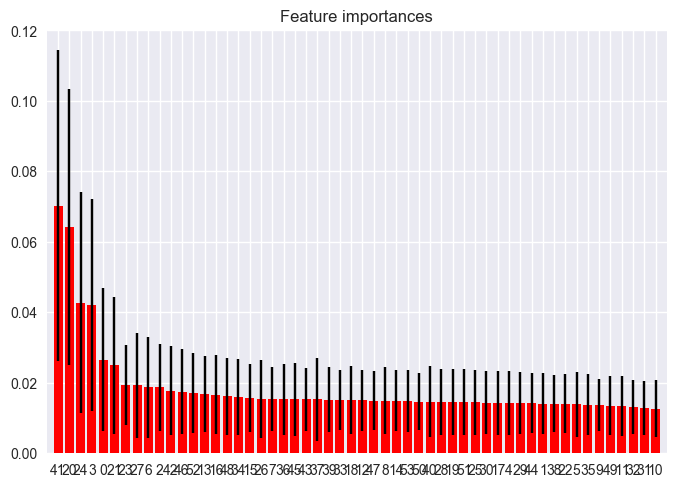

In [74]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns.values[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Gradient boosting decision tree

In [36]:
gb_model_1 = GradientBoostingClassifier()

C = {'n_estimators':[400,500,600,700],'learning_rate': [0.001, 0.01, 0.1], 'max_depth' : [3,4,5,6,7]}

clf = grid_search.GridSearchCV(estimator=gb_model_1, param_grid=C,n_jobs=-1,cv=3,scoring='neg_log_loss')

#Train the model
clf.fit(X_train,y_train)

#Best value of C 
print ('Best C:',clf.best_estimator_)

Best C: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=400, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)


In [37]:
model = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=400, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
model.fit(X_train,y_train)

print ('Train accuracy:')
print (metrics.accuracy_score(y_train, model.predict(X_train)))
print (metrics.log_loss(y_train, model.predict_proba(X_train)[:,1]))

print ('\nTest accuracy:')
print (metrics.accuracy_score(y_test, model.predict(X_test)))
print (metrics.log_loss(y_test, model.predict_proba(X_test)[:,1]))

Train accuracy:
0.778630460449
0.480967596331

Test accuracy:
0.708955223881
0.565129825573


# XGBoost

In [77]:
from sklearn import grid_search

xgb_model_1 = XGBClassifier()

C = {'n_estimators':[400,500,600,700],'learning_rate': [0.001, 0.01, 0.1], 'max_depth' : [3,4,5,6,7]}

clf = grid_search.GridSearchCV(estimator=xgb_model_1, param_grid=C,n_jobs=-1,cv=3,scoring='neg_log_loss')

#Train the model
clf.fit(X_train,y_train)

#Best value of C 
print ('Best C:',clf.best_estimator_)

KeyboardInterrupt: 

In [76]:
model = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=700, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
model.fit(X_train,y_train)

print ('Train accuracy:')
print (metrics.accuracy_score(y_train, model.predict(X_train)))
print (metrics.log_loss(y_train, model.predict_proba(X_train)[:,1]))

print ('\nTest accuracy:')
print (metrics.accuracy_score(y_test, model.predict(X_test)))
print (metrics.log_loss(y_test, model.predict_proba(X_test)[:,1]))

Train accuracy:
0.850649350649
0.419649081215

Test accuracy:
0.65671641791
0.593366816417


Feature ranking:
1. elo_opp (0.070276)
2. elo (0.064323)
3. diff_opp (0.042647)
4. diff (0.042055)
5. Result (0.026486)
6. Result_opp (0.024950)
7. blk_opp (0.019363)
8. fgm_opp (0.019242)
9. fgm (0.018736)
10. blk (0.018694)
11. de (0.017730)
12. orpct (0.017517)
13. orpct_opp (0.017179)
14. oppscore (0.016844)
15. score (0.016537)
16. de_opp (0.016115)
17. oppscore_opp (0.015900)
18. pf (0.015672)
19. fga_opp (0.015416)
20. fgm3 (0.015371)
21. pf_opp (0.015334)
22. oe (0.015325)
23. efgp (0.015320)
24. score_opp (0.015283)
25. to_opp (0.015137)
26. ftp_opp (0.015122)
27. to (0.015049)
28. ftp (0.015017)
29. topct (0.014961)
30. fgp (0.014958)
31. oor (0.014956)
32. topct_opp (0.014774)
33. ftr_opp (0.014652)
34. tr_opp (0.014629)
35. fgm3_opp (0.014548)
36. tr (0.014544)
37. oe_opp (0.014495)
38. dr_opp (0.014469)
39. fgp3_opp (0.014346)
40. stl (0.014237)
41. dr (0.014232)
42. fgp_opp (0.014200)
43. ftr (0.014196)
44. ast (0.014112)
45. stl_opp (0.014065)
46. ast_opp (0.014048)
47. 

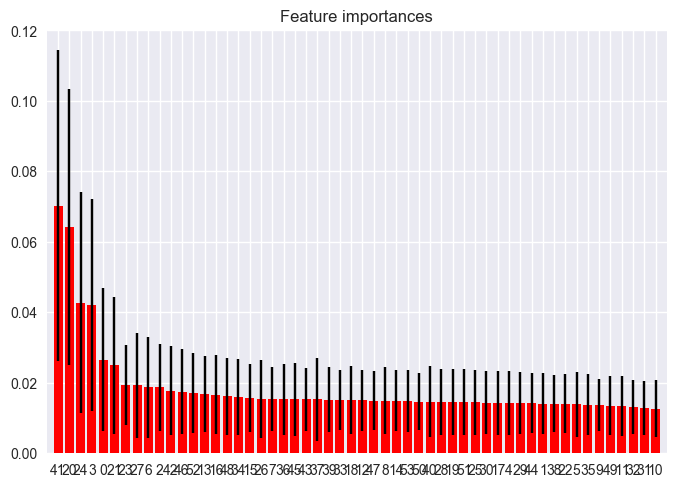

In [74]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns.values[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# SVM

In [ ]:
from sklearn.svm import SVC

#Build the SVM model
C = {'C':[0.01,0.1,1,10,100]}
svm_linear = SVC(kernel = 'linear', probability = True)
clf = grid_search.GridSearchCV(estimator=svm_linear, param_grid=C, cv=3,scoring='neg_log_loss')

#Train the model
clf_train = clf.fit(X_train,y_train)

#Predict
clf_pred_train = clf.predict(X_train)
clf_pred_test = clf.predict(X_test)

#Best value of C 
print ('Best value of C:',clf.best_estimator_)

In [49]:
model = SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
model.fit(X_train,y_train)

print ('Train accuracy:')
print (metrics.accuracy_score(y_train, model.predict(X_train)))
print (metrics.log_loss(y_train, model.predict_proba(X_train)[:,1]))

print ('\nTest accuracy:')
print (metrics.accuracy_score(y_test, model.predict(X_test)))
print (metrics.log_loss(y_test, model.predict_proba(X_test)[:,1]))

Train accuracy:
0.703069657615
0.544116760949

Test accuracy:
0.701492537313
0.559567396238


In [51]:
from sklearn.svm import SVC

#Build the SVM model
C = {'C':[0.01,0.1,1,10,100]}
svm_linear = SVC(kernel = 'rbf', probability = True)
clf = grid_search.GridSearchCV(estimator=svm_linear, param_grid=C, cv=3,scoring='neg_log_loss')

#Train the model
clf_train = clf.fit(X_train,y_train)

#Predict
clf_pred_train = clf.predict(X_train)
clf_pred_test = clf.predict(X_test)

#Best value of C 
print ('Best value of C:',clf.best_estimator_)

Best value of C: SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [52]:
model = SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
model.fit(X_train,y_train)

print ('Train accuracy:')
print (metrics.accuracy_score(y_train, model.predict(X_train)))
print (metrics.log_loss(y_train, model.predict_proba(X_train)[:,1]))

print ('\nTest accuracy:')
print (metrics.accuracy_score(y_test, model.predict(X_test)))
print (metrics.log_loss(y_test, model.predict_proba(X_test)[:,1]))

Train accuracy:
1.0
0.69314718056

Test accuracy:
0.522388059701
0.69314718056
